In [36]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import scipy.ndimage

import seaborn as sns
sns.set_style('white')
sns.set_context("notebook") #[poster, paper, talk, notebook]

## FUNCTIONS

In [132]:
def subregion_size(ds):
    dx = ds.x.max().values - ds.x.min().values
    dy = ds.y.max().values - ds.y.min().values
    return dx, dy


def plot_sd(ds, title, time=31, cmap='Blues', vmax=300):
    s = ds.isel(time=time)
    x_gt0 = s.snow.where(s.snow>0)
    x_gt0.plot.imshow(x='x', y='y', cmap=cmap, vmax=vmax, cbar_kwargs={'label': 'Snow Depth [cm]'})
    plt.tight_layout()

    
def kernel(n):
    # create mean filter 
    k = np.ones((n,n)) * 1./n**2
    return k

def smooth_over_grid(ds, k, time=31):
    s = ds.isel(time=time)
    smoothed = scipy.ndimage.convolve(s.snow, k)
    return smoothed

## DATA INPUTS

In [120]:
dx_input = 1000
flist = sorted(glob.glob('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_*{}m*'.format(dx_input))) #bsu
flist=flist[1]

In [123]:
flist = [flist]

## MAIN SCRIPT

In [124]:
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

k = kernel(100)

def smoother(f):
    # input (f): file
    # returns (smoothed_ds): xarray dataframe with smoothed snow layer
    
    ds = xr.open_dataset(f)#; ds.close() #open lidar snow depth DataSet in Xarray -- ds
    smooth_holder = np.zeros((51, 335, 335))
    smoothed_ds = ds.copy()
    for t in range(51):
           
        #grab a single time step
        subds = ds.isel(time=t).snow
        # apply the mean smoother filter 
        smooth_holder[t,:,:] = scipy.ndimage.convolve(subds, k)
        
    # done looping through time 
    # append the smoothed numpy ndarray to the newly copied xarray dataframe
    smoothed_ds['smoothed_snow'] = (('time','y','x'), smooth_holder)
    return smoothed_ds

list_of_smoothed_datasets = []
for f in flist:
    list_of_smoothed_datasets.append(smoother(f))

#         smoothed = smooth_over_grid(ds, k)
#         smoothed
#         plot_sd(smoothed, title=stns_longname[i], vmax=300); plt.show()
#         plt.imshow(smoothed, cmap='RdBu', vmax=300)
#         plt.title(stns_longname[i])
#         plt.colorbar()
#         plt.show()
        
        #plot difference


In [125]:
list_of_smoothed_datasets

[<xarray.Dataset>
 Dimensions:        (time: 51, x: 335, y: 335)
 Coordinates:
   * x              (x) float32 286209.0 286212.0 286215.0 ... 287208.0 287211.0
   * y              (y) float32 4219329.0 4219326.0 ... 4218330.0 4218327.0
   * time           (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
     mask           (y, x) uint8 ...
     dem            (y, x) float32 ...
     veg            (y, x) float32 ...
 Data variables:
     snow           (time, y, x) int16 ...
     smoothed_snow  (time, y, x) float64 1.043e+04 1.044e+04 ... 3.371e+03]

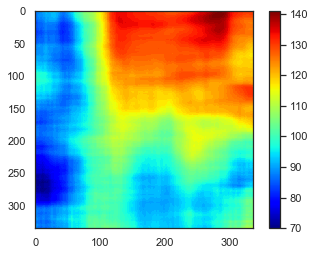

In [140]:
# Single time example...
flist = sorted(glob.glob('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_*{}m*'.format(dx_input))) #bsu
f = flist[0]
k = kernel(75)
ds = xr.open_dataset(f)
snow_3m = ds.isel(time=31).snow
snow_smooth = scipy.ndimage.convolve(snow_3m, k)
plt.imshow(snow_smooth, cmap='jet')
plt.colorbar()




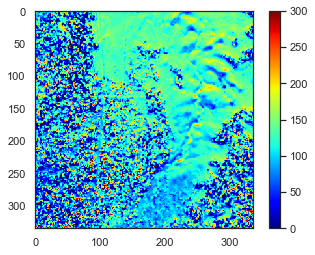

In [139]:
plt.imshow(snow_3m, cmap='jet', vmax=300)
plt.colorbar()



In [ ]:
# (smoothed_ds.smoothed_snow - smoothed_ds.snow).plot(x='x', y='y', col='time', col_wrap=10)
smoothed_ds.smoothed_snow.plot(x='x', y='y', col='time', col_wrap=10)

In [44]:
subds.snow.values

array([[87, 67, 93, ...,  0,  0,  0],
       [84, 66, 57, ...,  0,  0,  0],
       [88, 83, 47, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 35,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 44, 44,  0]], dtype=int16)

### TEST EVERYTHING

In [34]:
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 335, y: 335)
Coordinates:
  * x        (x) float32 292983.0 292986.0 292989.0 ... 293982.0 293985.0
  * y        (y) float32 4195203.0 4195200.0 4195197.0 ... 4194204.0 4194201.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 ...
    dem      (y, x) float32 ...
    veg      (y, x) float32 ...
Data variables:
    snow     (time, y, x) int16 ...

In [30]:
ds.x.count().values

array(335)

In [ ]:
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

k = kernel(50)

for i, f in enumerate(flist):
    
        print('Met Station Name:', stns_longname[i], '\n station ID:', stns[i])

        ds = xr.open_dataset(f); ds.close() #open lidar snow depth DataSet in Xarray -- ds

        print('x direction length {} [m]:'.format(ds.x.max().values - ds.x.min().values))
        print('y direction length {} [m]:'.format(ds.y.max().values - ds.y.min().values))

        dx, dy = subregion_size(ds) #subregion size -- used in figure naming

        plot_sd(ds, title=stns_longname[i], vmax=200);plt.show()